# US Accidents Modelling

## Data loading and copying
## A) Manual Testing
### + Data Preparation
### + Cross-validation
### + Lasso Hyperparameter Testing
## B) Feature Testing
### + Cross-validation with Optimized Parameters
### + Linear Regression
## C) Other Machine Learning Models:
### + SGDRregressor
### + KNNClassification
### + LogisticRegression??
### + Random Forest??

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

#from sklearn.metrics import mean_squared_error


## Load data and make a copy:

In [3]:
df = pd.read_csv('dec19_400k_rs1_edt_fillna.csv')

In [4]:
df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)

In [ ]:
#df.info()

In [5]:
df_copy = df.copy() # make a copy of df

In [6]:
#df_copy.info()

## A) Manual Testing:

#### Data Preparation for testing:

In [7]:
# list of 'Blocks' of features used in testing:

# Features excluded from model tests:
excluded_features = ['ID', 'Source', 'TMC', 'End_Lat', 'End_Lng', 'Street', 'City', 'Country','Description',
                     'Number','End_Time', 'County','Zipcode','Timezone', 'Airport_Code', 
                     'Civil_Twilight', 'Astronomical_Twilight', 'Nautical_Twilight', 'Weather_Timestamp',
                    'Start_Time']

# Basic numeric features:
basic_features = ['Severity','Start_Lat', 'Start_Lng', 'Distance(mi)', 'Precipitation_filled',
                 'Wind_Speed_filled_median', 'Humidity_filled_mean', 'Temperature_filled_mean',
                 'Visibility_filled_mean', 'Pressure_filled_mean', 'Wind_Chill_predicted_filled']


# Features replaced by *filled_mean or median:
replaced_features = ['Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
                    'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)',
                    'Wind_Speed_filled_mean', 'Temperature_filled_median']

# Traffic points of interest:
features_all_points_of_interest_bool = ['Traffic_Signal', 'Junction', 'Amenity','Bump',
                                    'Crossing','Give_Way','No_Exit', 'Railway','Roundabout',
                                    'Stop','Station','Traffic_Calming','Turning_Loop']

# wasnull features:
features_weather_wasnull = ['Precipitation_wasnull','Wind_Chill_wasnull','Wind_Speed_wasnull',
                            'Visibility_wasnull','Humidity_wasnull','Temperature_wasnull',
                            'Pressure_wasnull']


In [8]:
# test_batch1, containing 'Basic' numeric features:
test_batch1 = df.loc[:,basic_features]

# test_batch2, containing batch1 and other categorical features:
test_batch2 = pd.get_dummies(pd.concat([test_batch1,df.loc[:,['Traffic_Signal','Junction','Rush_Hour',
                                              'Side','Day_of_Week']]], axis=1))

# test_batch3 is test_batch2 + States:
test_batch3 = pd.get_dummies(pd.concat([test_batch2,df.loc[:,['State']]],axis=1))

# test_batch4 is test_batch3 + All points of interest + wasnull
temp1 = pd.concat([test_batch1, df.loc[:,features_all_points_of_interest_bool, 
                                       ]], axis=1)
temp2 = pd.concat([temp1, df.loc[:, ['Rush_Hour', 'Side', 'Day_of_Week', 'State']]], axis=1)
test_batch4 = pd.get_dummies(pd.concat([temp2, df.loc[:, features_weather_wasnull]], axis=1))

# test_batch5 is test_batch4 - wasnull:
test_batch5 = pd.get_dummies(temp2)


#### Cross-validation

In [ ]:
# Correlation between test_batch1 features and target:
plt.figure(figsize=(14, 6))
sns.heatmap(test_batch1.corr(),annot=True, cmap='BrBG',center=0);

In [ ]:
# test_batch1, containing 'Basic' numeric features:
test_batch1 = df.loc[:,basic_features]

In [ ]:
# Split data into features and target data:
X = test_batch1.iloc[:,1:]
y = test_batch1.iloc[:,0]

In [ ]:
""" Running cross-validation for all 3 regressions, using default parameters"""

cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=12)

cross_val_lr = cross_val_score(LinearRegression(), X, y, cv=cv)
cross_val_lasso =  cross_val_score(Lasso(), X, y, cv=cv)
cross_val_ridge = cross_val_score(Ridge(), X, y, cv=cv)


In [ ]:
cross_val_all = pd.DataFrame([cross_val_lr,cross_val_lasso, cross_val_ridge], 
                             index=['LinearReg','Lasso', 'Ridge'], columns=['cv:1', '2', '3', '4','5'])
cross_val_all

The cross-validation test using the default hyperparameters shows LinearRegression and Ridge outperforming Lasso. The accuracy of all models, is very low. We will attempt to improve this through:<br>
+ Adjusting the hyperparameters of each model, and
+ Adding other features to the model.

#### Lasso Hyperparameter testing:

In [ ]:
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)

In [ ]:
norm = [True, False]

for norm in normalizer:
    #run Lasso using True / False
    lasso = Lasso(alpha=0.01, normalize=norm, max_iter=100, selection='cyclic', 
                  fit_intercept=True, precompute=False, tol=0.0001)
    lasso.fit(X_train,y_train)
    lasso_pred = lasso.predict(X_test)
    lasso.score(X_test,y_test)
    print('Lasso Regression Test_set score for', norm ,'is', lasso.score(X_test,y_test))
    print('Lasso Regression Train_set score for', norm, 'is', lasso.score(X_train, y_train))
    print("Number of features used:", len(lasso.coef_))
    # plot results
    plt.scatter(lasso_pred, y_test)
    plt.xlabel("Predicted")
    plt.ylabel("Original")
    plt.title(norm)
    plt.show()
    

### B) Feature Testing

#### Cross-validation with Optimized Hyperparameters:

In [20]:
# list of dataframes of feature combinations:
dfs = [test_batch1, test_batch2, test_batch3, test_batch4, test_batch5]
#dfs = [test_batch1, test_batch2]
cross_val_avg_all=[]

# loop through dataframes:
for d in dfs:
    
    X = d.iloc[:,1:]
    y = d.iloc[:,0]

    """ Running cross-validation for all 3 regressions, using default parameters"""

    cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=12)

    cross_val_lr = cross_val_score(LinearRegression(), X, y, cv=cv)
    cross_val_lasso =  cross_val_score(Lasso(alpha=0.01), X, y, cv=cv)
    cross_val_ridge = cross_val_score(Ridge(alpha=0.01), X, y, cv=cv)

    #Calculate mean of all 5batches of cross-validation for all feature dataframes:
    cross_val_avg =[np.mean(cross_val_lr), np.mean(cross_val_lasso), np.mean(cross_val_ridge)]
                           
    cross_val_avg_all.append(cross_val_avg)

#cross_val_all = pd.DataFrame([cross_val_lr,cross_val_lasso, cross_val_ridge], 
#                             index=['LinearReg','Lasso', 'Ridge'], columns=['cv:1', '2', '3', '4','5'])
#cross_val_all

In [28]:
pd.DataFrame(cross_val_avg_all, index=['batch1_score', 'batch2', 'batch3', 'batch4', 'batch5'],
             columns=['LinearReg', 'Lasso', 'Riddge']).transpose()

,batch1_score,batch2,batch3,batch4,batch5
LinearReg,0.028692,0.108821,0.141902,0.146716,0.145245
Lasso,0.027517,0.088920,0.088920,0.089612,0.088920
Riddge,0.028692,0.108821,0.141902,0.146716,0.145245


From the cross-validations above, LinearRegression and Ridge have similar scores. Moving forward, a LinearRegression will be run using train and test datasets. To check the accuracy of the model, the following calculations are conducted:
+ Train and test set scores.
+ RMSE for both train and test data.

#### LinearRegression:

In [ ]:
# Split data into features and target data:
X = test_batch1.iloc[:,1:]
y = test_batch1.iloc[:,0]

In [ ]:
# Split data into train and test sets:
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)

In [ ]:
from sklearn import metrics

In [ ]:
normalizer = [True, False]

for norm in normalizer:
    
    lr = LinearRegression(normalize=norm, fit_intercept=True)
    lr.fit(X_train,y_train)
    lr_pred = lr.predict(X_test)
    lr.score(X_test,y_test)
    
    #Calculate train/test score:
    print('LinearRegression Test_set score for', norm ,'is', lr.score(X_test,y_test))
    print('LinearRegression Train_set score for', norm, 'is', lr.score(X_train, y_train))
    
    # Calulate rmse:
    rmse_test = np.sqrt(metrics.mean_squared_error(y_test, lr.predict(X_test)))
    print('rmse of Test_set = ', rmse_test)
    rmse_train = np.sqrt(metrics.mean_squared_error(y_train, lr.predict(X_train)))
    print('rmse of Train_set = ', rmse_train)
    
    # plot test results
    plt.scatter(lr_pred, y_test)
    plt.xlabel("Predicted")
    plt.ylabel("Original")
    plt.title(norm)
    plt.show()
    

In the linearRegression above, normalization does not change the output. This is possibly because of the close ranges in values of the features in the dataset.  For instance, categorical data ranges between (0,1), Precipitation has the range (0-10.1), Temperature (-77 to -168), Pressure (0.3 - 31), and Start_Lng(-124.49 to -67.6).

### C) Other Machine Learning Models:

#### SGDRegressor:

In [170]:
from sklearn.linear_model import SGDRegressor

In [171]:
# Split data into features and target data:
X = test_batch5.iloc[:,1:]
y = test_batch5.iloc[:,0]

In [172]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=12)

In [173]:
# Scale/normalize the data:
scaler = StandardScaler()
scaler.fit(X_train)
Xn_train = scaler.transform(X_train)
Xn_test = scaler.transform(X_test)

C:\Users\Toshiba\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype bool, uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Toshiba\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype bool, uint8, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
C:\Users\Toshiba\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype bool, uint8, float64 were all converted to float64 by StandardScaler.
  """


In [174]:
sgdregres = SGDRegressor()

In [ ]:
# Grid search to find optimum hyperparameters
param_grid = {
    'alpha': 10.0 ** -np.arange(0, 2),
    'loss': ['huber', 'epsilon_insensitive', 'squared_loss'],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'learning_rate': ['constant', 'optimal', 'invscaling'],
}
clf = GridSearchCV(sgdregres, param_grid, cv=5)
clf.fit(Xn_train, y_train)
print(clf.best_params_)
print("Best score: ", str(clf.best_score_))

In [ ]:
# Run model with optimum Hyper parameters:
sgdregres = SGDRegressor(alpha=1, learning_rate='optimal', loss='squared_loss', 
                      penalty='l2', random_state=12)
# fit model:
sgdregres.fit(Xn_train, y_train)

# predict y:
sgdregres_pred = sgdregres.predict(Xn_test)

#Calculate score:
sgdregres.score(Xn_test,y_test)
print('SGD Regression Test_set score for Test is:', sgdregres.score(Xn_test,y_test))
print('SGD Regression Train_set score for Train is:', sgdregres.score(Xn_train, y_train))
print("Number of features used:", len(sgdregres.coef_))

# Calculate rmse:
rmse_test = np.sqrt(metrics.mean_squared_error(y_test, sgdregres.predict(Xn_test)))
print('rmse of Test_set = ', rmse_test)
rmse_train = np.sqrt(metrics.mean_squared_error(y_train, sgdregres.predict(Xn_train)))
print('rmse of Train_set = ', rmse_train)
    
# plot results
plt.scatter(sgdregres_pred, y_test)
plt.xlabel("Predicted")
plt.ylabel("Original")
plt.title('SGD Algorithm')
plt.show()

#### KNN Classification:

In [175]:
X_train, X_test, y_train, y_test = train_test_split(
    test_batch1.iloc[:,1:3], test_batch1.iloc[:,0], test_size=0.3, random_state=12)

In [176]:
# Scale/normalize the data:
scaler = StandardScaler()
scaler.fit(X_train)

Xn_train = scaler.transform(X_train)
Xn_test = scaler.transform(X_test)

In [58]:
from sklearn.neighbors import KNeighborsClassifier

In [177]:
# model

classifier = KNeighborsClassifier(n_neighbors=3)
classifier.fit(Xn_train, y_train)

# fit model
classifier.fit(Xn_train, y_train)

# predict y
classifier_pred = classifier.predict(Xn_test)


In [178]:
from sklearn.metrics import classification_report, confusion_matrix
# calculate confusion_matrix and classification_report:

print(confusion_matrix(y_test, classifier_pred))
print(classification_report(y_test, classifier_pred))

[[    0    33     5     0]
 [    9 68918 10688   683]
 [    0  8980 26675   277]
 [    0  2191   962   579]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        38
           2       0.86      0.86      0.86     80298
           3       0.70      0.74      0.72     35932
           4       0.38      0.16      0.22      3732

   micro avg       0.80      0.80      0.80    120000
   macro avg       0.48      0.44      0.45    120000
weighted avg       0.80      0.80      0.80    120000



In [179]:
#Calculate score
classifier.score(Xn_test,y_test)
print('KNN Test_set score is:', classifier.score(Xn_test,y_test))
print('KNN Train_set score is:', classifier.score(Xn_train, y_train))

KNN Test_set score is: 0.8014333333333333
KNN Train_set score is: 0.879075


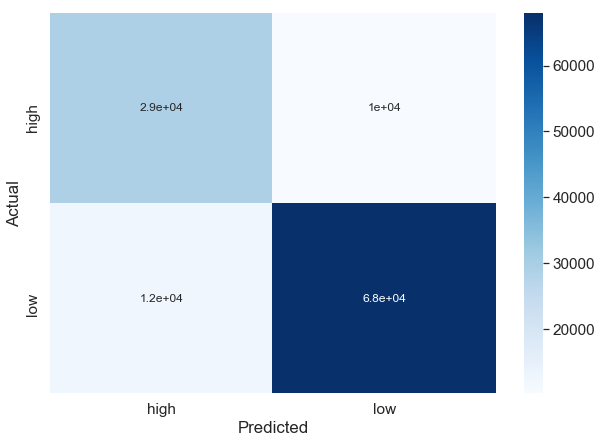

In [169]:
# plot confusion matrix
#data = confusion_matrix(y_test, classifier_pred)
#df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
#df_cm.index.name = 'Actual'
#df_cm.columns.name = 'Predicted'
#plt.figure(figsize = (10,7))
#sns.set(font_scale=1.4)#for label size
#sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 12});

In [105]:
# Make two classes low[1 and 2], and high [3 and 4]:
test_batch1_low_high = test_batch1.replace(to_replace={'Severity':{1:'low', 2:'low', 3:'high', 4:'high'}})

In [181]:
# plot confusion matrix
data = confusion_matrix(y_test, classifier_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = ['Actual1','Actual2','Actual3','Actual4']
df_cm.columns.name = ['Predicted1', 'Predicted2','Predicted3','Predicted4']
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 12});

ValueError: Shape of passed values is (4, 4), indices imply (2, 2)

In [106]:
#low = test_batch1[(test_batch1['Severity']== 1)| (test_batch1['Severity']== 2)]
#high = test_batch1[(test_batch1['Severity']== 3)| (test_batch1['Severity']== 4)]
#
#print('Total low number of rows:', low.Severity.value_counts().sum()),
#print('Total high number of rows:', high.Severity.value_counts().sum())

#### Logistic Regression:

#### Random Forest: